In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/Users/aytijhyasaha/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aytijhyasaha/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


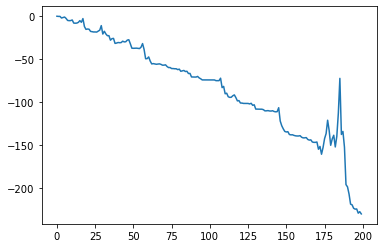

In [2]:
def e_detector_sr(data, lmbda):
    N = len(data)
    E = np.zeros((N, N))
    for j in range(N):
        for i in range(j, N):
            l = max(lmbda, np.mean(data[j:i]))
            if i == 0 and j == 0:
                E[j, i] = data[i] * np.log(l / lmbda) - l + lmbda
            else:
                E[j, i] = E[j, i - 1] + data[i] * np.log(l / lmbda) - l + lmbda
    return np.sum(E, axis=0)

data = np.random.poisson(300, 200)

plt.plot(e_detector_sr(data, 300))
plt.show()

/Users/aytijhyasaha/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aytijhyasaha/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


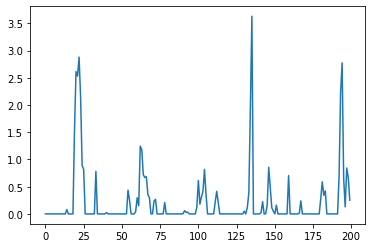

In [3]:
def e_detector_cusum(data, lmbda):
    N = len(data)
    E = np.zeros((N, N))
    for j in range(N):
        for i in range(j, N):
            l = max(lmbda, np.mean(data[j:i]))
            if i == 0 and j == 0:
                E[j, i] = data[i] * np.log(l / lmbda) - l + lmbda
            else:
                E[j, i] = E[j, i - 1] + data[i] * np.log(l / lmbda) - l + lmbda
    return np.max(E, axis=0)

data = np.random.poisson(300, 200)

plt.plot(e_detector_cusum(data, 300))
plt.show()

/Users/aytijhyasaha/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aytijhyasaha/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


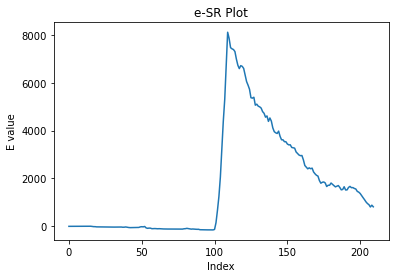

In [4]:
data = np.concatenate((np.random.poisson(30, 100), np.random.poisson(80, 10), np.random.poisson(30, 100)))

plt.plot(e_detector_sr(data, 30))
plt.xlabel("Index")
plt.ylabel("E value")
plt.title("e-SR Plot")
plt.show()

In [5]:
model_ids = ['180703949','170803729','140624423']
#parameters
num = 0
model_id = model_ids[num]
fluences=np.arange(start=0, stop=351, step=10)
hmax=256
bin_width=0.05
fluences
fluence=1000
data = pd.read_csv("simulations.csv", index_col="time") #contains simulations of each burst containing 10000 photons

#plt.savefig(f'plots/grb{num}_pic.png', dpi=150)

Text(0.5, 1.0, 'Simulation of GRB 180703949 with photon count 1000')

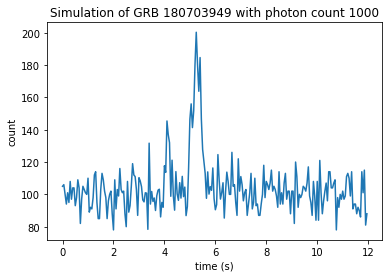

In [6]:
background = data['background']
burst_shape = data[model_id]
grb = background + fluence/100000 * burst_shape #rescaled model of burst with background
grb.plot()
plt.xlabel('time (s)')
plt.ylabel('count')
plt.title(f'Simulation of GRB {model_id} with photon count {fluence}')

In [24]:
sr = np.zeros((17, 3))
cusum = np.zeros((17, 3))
id_vals = np.arange(0, 161, 10)

for i in range(17):
    for j in range(3):
        grb = data['background'] + id_vals[i] / 100000 * data[model_ids[j]]
        cusum[i, j] = np.max(e_detector_cusum(np.array(grb), 100))
        sr[i, j] = np.max(e_detector_sr(np.array(grb), 100))



/Users/aytijhyasaha/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aytijhyasaha/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [58]:
def binning(data, bin_width=0.05):
    grb_counts = pd.DataFrame(data)
    grb_counts[0] = grb_counts[0]-grb_counts.loc[0, 0]
    first = 0; last = grb_counts.iloc[-1, 0]

    bins = np.arange(first, last+bin_width, bin_width)
    bin_map = pd.cut(grb_counts[0], bins=bins).apply(lambda I: I.left)
    bin_series = pd.DataFrame(bin_map).groupby(0)[0].count()
    bin_df = pd.DataFrame({'count':bin_series})
    return bin_df

def window_detection(signal, λ, σ=5, hmax=128, spacing='logarithmic'):

    if spacing=='logarithmic':
        window_lengths = 2**(np.arange(0, np.ceil(np.log2(hmax)))).astype(int)
    else:
        window_lengths = np.arange(1, hmax+1)

    max_threshold=0
    best_window=1

    for h in window_lengths:

        data = signal.rolling(window=h).mean()
        μ = data/λ

        lr_statistic = 2*h*λ*(μ*np.log(μ)-μ+1) * (μ>1)


        if lr_statistic.max() > max_threshold:
            max_threshold = lr_statistic.max()
            best_window=h

    sigma_level = np.sqrt(max_threshold*2)
    return sigma_level

In [62]:
#exhaustive

output = []

for fluence in id_vals:

    grb = background + fluence/100000 * burst_shape
    output.append(window_detection(grb, λ=100, hmax=hmax, spacing='exhaustive'))



In [63]:
k = np.arange(4, 5.1, 0.1)
arl = np.array([5623.34, 8449.74, 12277.34, 18940.88, 24567.46, 48482.06, 64692.74,
                108519.70, 171507.50, 278664.94, 405373.90])



# Assuming you have defined rel and focus arrays
rel = np.interp( output, k, arl)

result = {
    "e-CUSUM": cusum[:, 0],
    "e-SR": sr[:, 0],
    "FOCuS": np.log(rel)
}

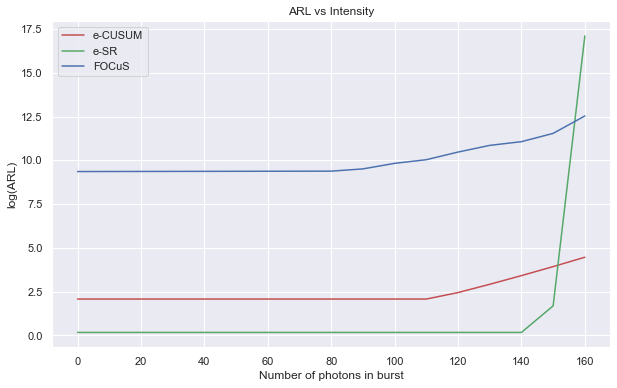

In [64]:
result= pd.DataFrame(result)
plt.figure(figsize=(10, 6))
colors=['r','g','b']
l=["e-CUSUM","e-SR","FOCuS"]
for i in range(3):
    plt.plot(id_vals,result.iloc[:,i],color=colors[i], label=l[i])

plt.xlabel("Number of photons in burst")
plt.ylabel("log(ARL)")
plt.title("ARL vs Intensity")
plt.legend()
plt.show()
